# Preamble

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as ss
import scipy.special as ssp
import pymc as pm
import arviz as az
import pytensor.tensor as at
import pytensor.tensor.extra_ops as ate
import corner

# Data Generation

We generate observations $x_o$'s as:
$$
x_t \sim G(x_t|\mu_t=0, \sigma_t=1)
$$

$$
x_o \sim G(x|\mu=x_t, \sigma_{obs}=1)
$$

G refers to the Gaussian distribution.

In [2]:
mut = 0
sigmat = 1
sigmao = 1
Nobs = 10000

xt = np.random.normal(mut, sigmat, Nobs)
xo = np.random.normal(xt, sigmao, Nobs)

# Inference for Data without Selection Cut
$$
P(\mu, \sigma|\vec{x_o}) \propto \text{Prior}(\mu, \sigma) \mathcal{L}(\vec{x_o}|\mu, \sigma)
$$

$$
\mathcal{L}(\vec{x_o}|\mu, \sigma) = \prod_{i=1}^{N_{obs}} G(x_{oi}|\mu, \sqrt{\sigma_{obs}^2+\sigma^2})
$$

In [3]:
def make_model(xo, sigmao):

    with pm.Model() as model:        
        mu = pm.Uniform('mu', -3, 3) #in solar mass unit
        sigma = pm.Uniform('sigma', 0.01, 3)

        pm.Normal('dL_likelihood', mu=mu, sigma=at.sqrt(sigma**2+sigmao**2), observed=xo)
    return model

In [4]:
def plot_corner(trace, xcut, xcor=0.6, ycor=0.98):
    data = np.array([np.array(trace.posterior.mu).flatten(),np.array(trace.posterior.sigma).flatten()]).T
    true = np.array([mut, sigmat])
    figure = corner.corner(
        data,
        labels=[
            r"$\mu$",
            r"$\sigma$",
        ],
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 12},
    )
    
    # Extract the axes
    axes = np.array(figure.axes).reshape((len(true), len(true)))
    
    # Loop over the diagonal
    for i in range(len(true)):
        ax = axes[i, i]
        ax.axvline(true[i], color="r")
    
    
    
    # Loop over the histograms
    for yi in range(len(true)):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(true[xi], color="r")
            ax.axhline(true[yi], color="r")
            ax.plot(true[xi], true[yi], "sr")

    plt.suptitle(r'$x_{cut}=$'+str(xcut), x=xcor, y=ycor)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


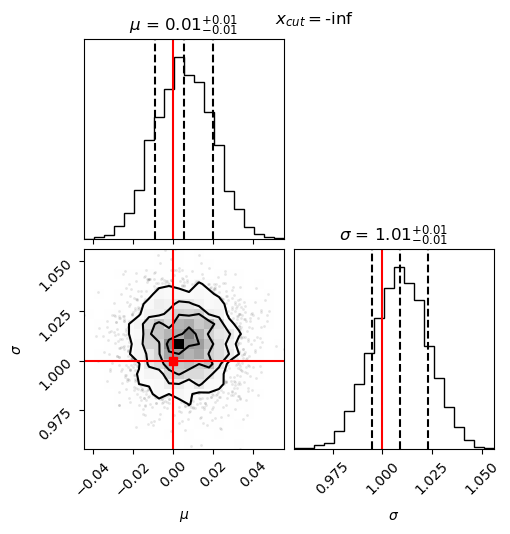

In [5]:
with make_model(xo, sigmao) as model:
    trace = pm.sample()

plot_corner(trace, xcut=-np.inf)

# Inference for Data with Selection Cut
Selecting data with $x_o>x_{cut}$.

Log-likelihood is:
$$
\log \mathcal{L}(\vec{x_o}|\mu, \sigma) = -N_{obs}\log(1-\Phi\Bigg(\frac{x_{cut}-\mu}{\sqrt{\sigma_{obs}^2+\sigma^2}}\Bigg)) + \sum_{i=1}^{N_{obs}} \log G(x_{oi}|\mu, \sqrt{\sigma_{obs}^2+\sigma^2})
$$

Note, even if $\sigma_{obs}=0$, the selection function does not vanish. This is because it acts as hyperparameter dependent normalization of the likelihood.

In [6]:
def xo_cut(Nobs, xcut, mu=mut, sigma=sigmat, sigmao=sigmao):
    xo = []
    while len(xo)<Nobs:
        xt = np.random.normal(mut, sigmat)
        xo_m = np.random.normal(xt, sigmao)
        if xo_m>=xcut:
            xo.append(xo_m)
    xo = np.array(xo)
    print('len(xo)=', len(xo), 'xo<xcut:', np.where(xo<xcut))
    return xo

In [7]:
def make_model_cut(xo, xcut, sigmao=sigmao):
    Nobs = len(xo)

    with pm.Model() as model:        
        mu = pm.Uniform('mu', -3, 3) #in solar mass unit
        sigma = pm.Uniform('sigma', 0.01, 3)

        _ = pm.Normal('likelihood', mu=mu, sigma=at.sqrt(sigma**2+sigmao**2), observed=xo)

        # Selection Function
        rv = pm.Normal.dist(0.0, 1.0)
        value = (xcut-mu)/at.sqrt(sigma**2+sigmao**2)
        rv_logcdf = pm.logcdf(rv, value)
        var = 1-at.exp(rv_logcdf)      
        _ = pm.Potential('sel', -Nobs*at.log(var))
    return model

### $x_{cut}=\mu-3\sigma$

len(xo)= 10000 xo<xcut: (array([], dtype=int64),)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


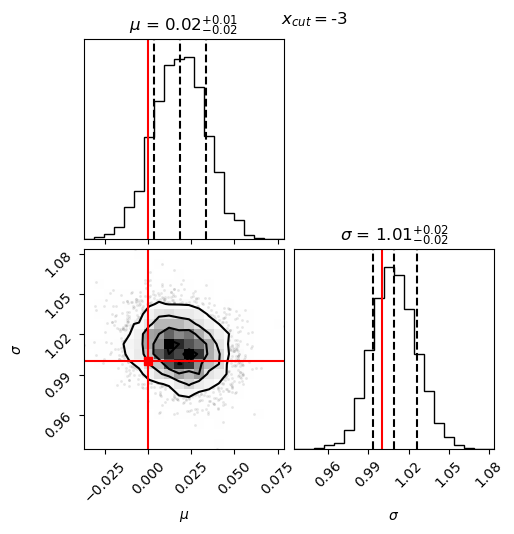

In [11]:
xcut = -3
xo = xo_cut(Nobs=Nobs, xcut=xcut)

with make_model_cut(xo, xcut) as model:
    trace = pm.sample()

plot_corner(trace, xcut)

### $x_{cut}=\mu-2\sigma$

len(xo)= 10000 xo<xcut: (array([], dtype=int64),)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


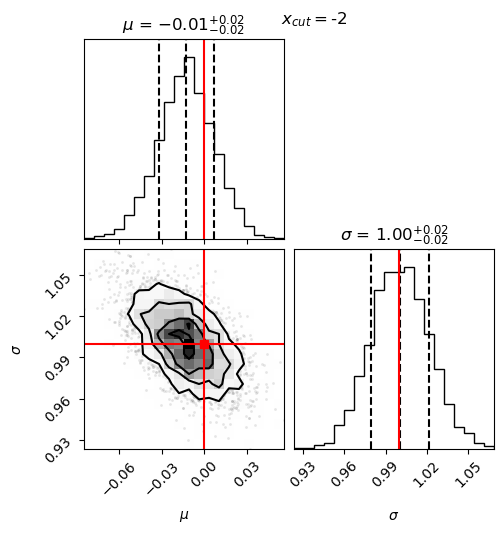

In [12]:
xcut = -2
xo = xo_cut(Nobs=Nobs, xcut=xcut)

with make_model_cut(xo, xcut) as model:
    trace = pm.sample()

plot_corner(trace, xcut)

### $x_{cut}=\mu-\sigma$

len(xo)= 10000 xo<xcut: (array([], dtype=int64),)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


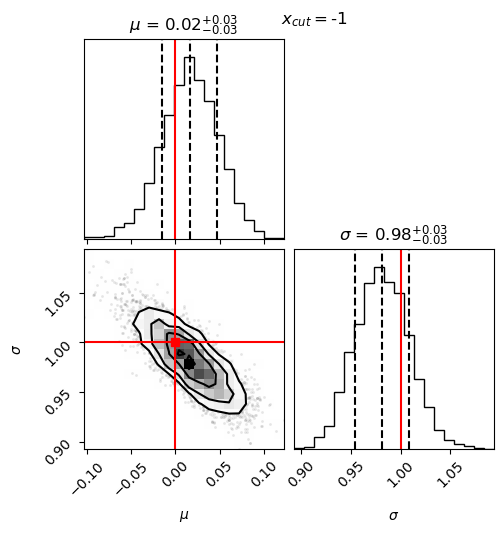

In [13]:
xcut = -1
xo = xo_cut(Nobs=Nobs, xcut=xcut)

with make_model_cut(xo, xcut) as model:
    trace = pm.sample()

plot_corner(trace, xcut)

### $x_{cut}=\mu$

len(xo)= 10000 xo<xcut: (array([], dtype=int64),)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


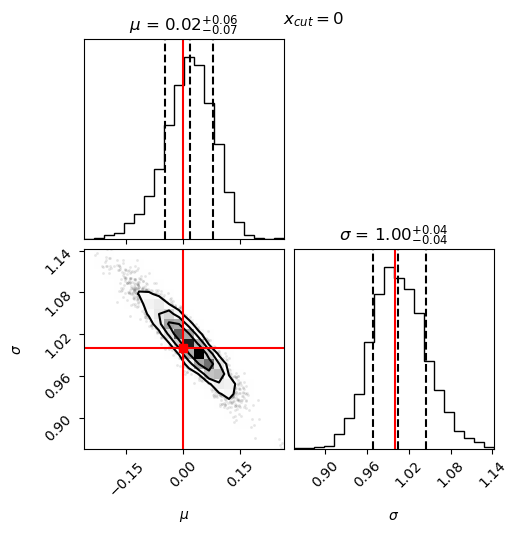

In [14]:
xcut = 0
xo = xo_cut(Nobs=Nobs, xcut=xcut)

with make_model_cut(xo, xcut) as model:
    trace = pm.sample()

plot_corner(trace, xcut)

### $x_{cut}=\mu+\sigma$

len(xo)= 10000 xo<xcut: (array([], dtype=int64),)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


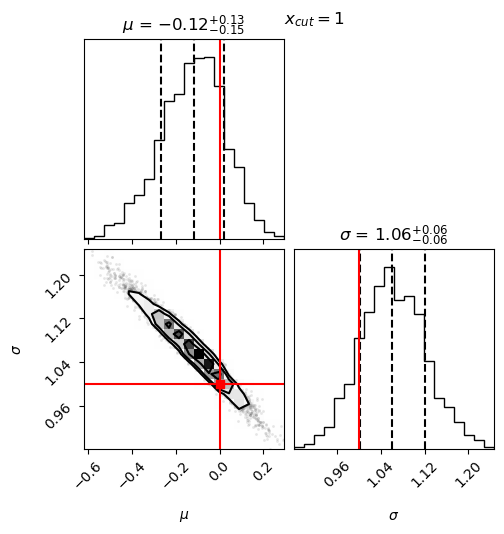

In [15]:
xcut = 1
xo = xo_cut(Nobs=Nobs, xcut=xcut)

with make_model_cut(xo, xcut) as model:
    trace = pm.sample()

plot_corner(trace, xcut)

### $x_{cut}=\mu+2\sigma$

len(xo)= 10000 xo<xcut: (array([], dtype=int64),)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


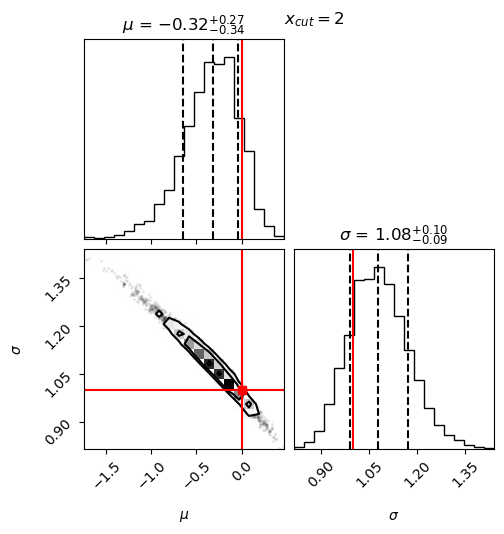

In [17]:
xcut = 2
xo = xo_cut(Nobs=Nobs, xcut=xcut)

with make_model_cut(xo, xcut) as model:
    trace = pm.sample()

plot_corner(trace, xcut)

### $x_{cut}=\mu+3\sigma$

len(xo)= 10000 xo<xcut: (array([], dtype=int64),)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


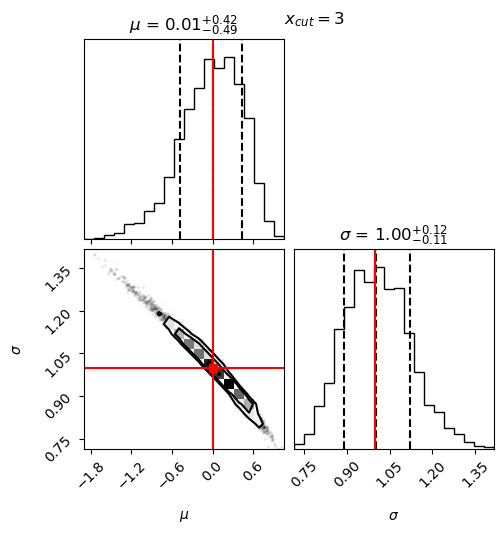

In [18]:
xcut = 3
xo = xo_cut(Nobs=Nobs, xcut=xcut)

with make_model_cut(xo, xcut) as model:
    trace = pm.sample()

plot_corner(trace, xcut)

### $x_{cut}=\mu+4\sigma$

len(xo)= 10000 xo<xcut: (array([], dtype=int64),)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


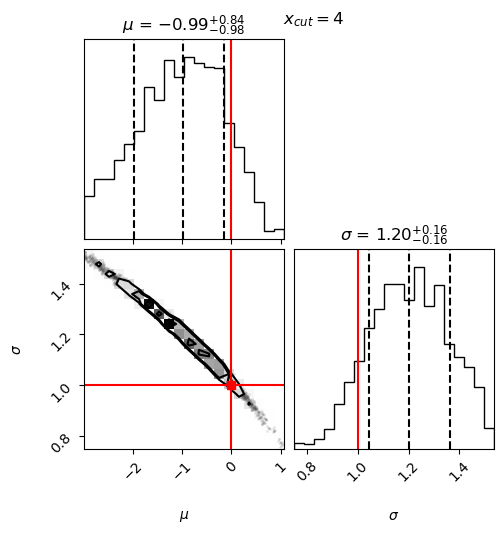

In [19]:
xcut = 4
xo = xo_cut(Nobs=Nobs, xcut=xcut)

with make_model_cut(xo, xcut) as model:
    trace = pm.sample()

plot_corner(trace, xcut)

### $x_{cut}=\mu+5\sigma$

len(xo)= 10000 xo<xcut: (array([], dtype=int64),)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


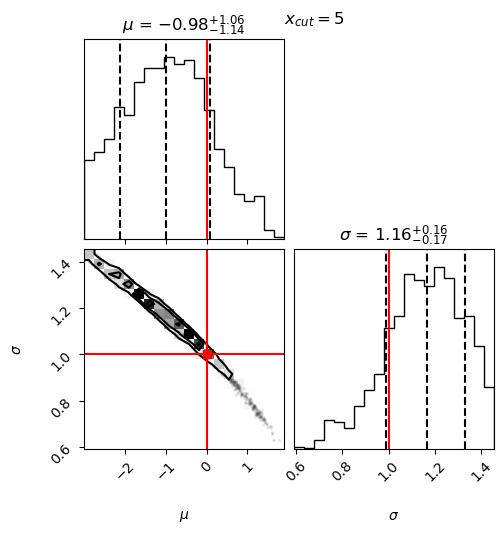

In [20]:
xcut = 5
xo = xo_cut(Nobs=Nobs, xcut=xcut)

with make_model_cut(xo, xcut) as model:
    trace = pm.sample()

plot_corner(trace, xcut)

# Observation from the Plots

#### As $x_{cut}$ becomes higher, correlation between $\mu$ and $\sigma$ becomes stronger.

#### The question is:

#### Can we explain this feature? Also can we find an allowed range of $x_{cut}$ such that we can infer $\mu, \sigma$?

# Expand Log-Likelihood around High $x_{cut}$

$$
\frac{\log \mathcal{L}}{N_{obs}} \approx \frac{1}{2\sigma_{eff}^2}[(x_{cut}^2-\bar{x_o^2})-2(x_{cut}-\bar{x}_o)\mu] + \log(x_{cut}-\mu) - \log (\sigma_{eff}^2) + \frac{\sigma_{eff}^2}{(x_{cut}-\mu)^2} - \frac{5}{2}\frac{\sigma_{eff}^4}{(x_{cut}-\mu)^4} + \frac{37}{3}\frac{\sigma_{eff}^6}{(x_{cut}-\mu)^6} + O\Bigg(\Big(\frac{x_{cut}-\mu}{\sigma_{eff}}\Big)^{-8}\Bigg)
$$

Here
$$
\sigma_{eff}^2 = \sigma_{obs}^2+\sigma^2, ~~~~\bar{x}_o=\frac{1}{N_{obs}}\sum_{i=1}^{N_{obs}} x_{oi}, ~~~~\bar{x_o^2}=\frac{1}{N_{obs}}\sum_{i=1}^{N_{obs}} x_{oi}^2
$$

# Range of $x_{cut}$
1. For $O(x_{cut}^2)$, $O(x_{cut})$ and $O\Big(\log\Big(\frac{x_{cut}-\mu}{\sigma_{eff}}\Big)\Big)$, Log-Likelihood does not have maxima for $\mu, \sigma$.
2. For $O(x_{cut}^0)$, Log-Likelihood has maxima for $\sigma$, but is linear in $\mu$.
3. For $O\Big(\Big(\frac{x_{cut}-\mu}{\sigma_{eff}}\Big)^{-2}\Big)$, we get maximum Likelihood estimate of $\mu$ and $\sigma$.

In our case, we know the exact analytical expression of the likelhood. But for realistic models, it will be a Monte Carlo sum of the parameter estimation samples and injections crossing the detection threshold. Hence in reality, we always have a Monte Carlo uncertainty associated with the log-likelihood, $\sigma_{\log \mathcal{L}}$. This needs to be smaller than the error we are making due to the asymptotic series expansion:

$$
\Big(\frac{x_{cut}-\mu}{\sigma_{eff}}\Big)^{-2}>\frac{\sigma_{\log \mathcal{L}}}{N_{obs}}>-\frac{5}{2}\Big(\frac{x_{cut}-\mu}{\sigma_{eff}}\Big)^{-4}
$$

Note

$$
\frac{\sigma_{\log \mathcal{L}}}{N_{obs}}>-\frac{5}{2}\Big(\frac{x_{cut}-\mu}{\sigma_{eff}}\Big)^{-4}
$$
will be automatically satisfied as $\sigma_{\log \mathcal{L}}, N_{obs}>0$. We get a stronger constraint if we add $O\Bigg(\Big(\frac{x_{cut}-\mu}{\sigma_{eff}}\Big)^{-6}\Bigg)$ term.

$$
\Big(\frac{x_{cut}-\mu}{\sigma_{eff}}\Big)^{-2}>\frac{\sigma_{\log \mathcal{L}}}{N_{obs}}>-\frac{5}{2}\Big(\frac{x_{cut}-\mu}{\sigma_{eff}}\Big)^{-4}+\frac{37}{3}\Big(\frac{x_{cut}-\mu}{\sigma_{eff}}\Big)^{-6}
$$

# Correlation between $\mu, \sigma$
From the coefficients of $\mu$ and $\sigma$ in the asymptotic series of log-likelihood, we get Fisher matrix between $\mu$ and $\sigma$ goes as $x_{cut}^{-n}$,
$$
F \sim x_{cut}^{-n}
$$
and covariance goes as,
$$
cov \sim x_{cut}^n
$$
where n are the even powers. Hence with $x_{cut}$ correlation between $\mu$ and $\sigma$ inceases. This explains why we are getting more degenerate measurements for higher $x_{cut}$.